In [8]:
import torch
import lightning as L
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import DDPMScheduler
from datasets import load_dataset
from torchvision import transforms
from diffusers import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.fabric.utilities import AttributeDict
from lightning.fabric import Fabric
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

In [2]:
image_size = 32
train_batch_size = 16
T = 1000
num_epochs = 50

Repo card metadata block was not found. Setting CardData to empty.


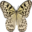

In [4]:
dataset = load_dataset(
    "huggan/smithsonian_butterflies_subset", 
    split="train", 
    cache_dir="./cache"
)

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

sample_image = dataset[0]["images"].unsqueeze(0)

Image.fromarray(((sample_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=train_batch_size, 
    shuffle=True,
    drop_last=False,
    pin_memory=True,
)

In [6]:
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 32, 64, 64, 128, 128),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

num_params = sum(p.numel() for p in model.parameters())
print(f"The model has {num_params:,} trainable parameters")

The model has 7,126,275 trainable parameters


In [14]:
fabric = L.Fabric(
    accelerator="auto", 
    devices="auto",
)

state = fabric.load("output/model.pt")
model.load_state_dict(state["model"])

<All keys matched successfully>

In [6]:
class DiffusionModel(L.LightningModule):
    def __init__(self, model, noise_scheduler):
        super().__init__()
        self.model = model
        self.noise_scheduler = noise_scheduler

    def training_step(self, batch, batch_idx):
        images = batch["images"]
        noise = torch.randn_like(images)
        steps = torch.randint(self.noise_scheduler.config.num_train_timesteps, (images.size(0),), device=self.device)
        noisy_images = self.noise_scheduler.add_noise(images, noise, steps)
        residual = self.model(noisy_images, steps).sample
        loss = torch.nn.functional.mse_loss(residual, noise)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = get_cosine_schedule_with_warmup(
            optimizer=optimizer,
            num_warmup_steps=500,
            num_training_steps=(len(train_dataloader) * num_epochs),
        )
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 1}}

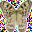

In [16]:
noise_scheduler = DDPMScheduler(num_train_timesteps=T)

noise = torch.randn(sample_image.shape)

timesteps = torch.LongTensor([10])

noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [12]:
noise_scheduler.set_timesteps(100)
noise_scheduler.timesteps[0]

tensor(990)

In [13]:
tlmodel = DiffusionModel(model, noise_scheduler)

In [14]:
trainer = L.Trainer(max_epochs=num_epochs, precision="32")
trainer.fit(tlmodel, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\mingx\anaconda3\envs\mingxuan\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#tor

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\mingx\anaconda3\envs\mingxuan\Lib\site-packages\diffusers\models\attention_processor.py:2358: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [21]:
eval_batch_size = 16
seed = 42
output_dir = "./output"

pipeline = DDPMPipeline(unet=model.to('cuda').eval(), scheduler=noise_scheduler)
    
def evaluate(epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=eval_batch_size,
        generator=torch.Generator(device='cuda').manual_seed(seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
        num_inference_steps=1
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [22]:
evaluate(epoch=2, pipeline=pipeline)

  0%|          | 0/1 [00:00<?, ?it/s]

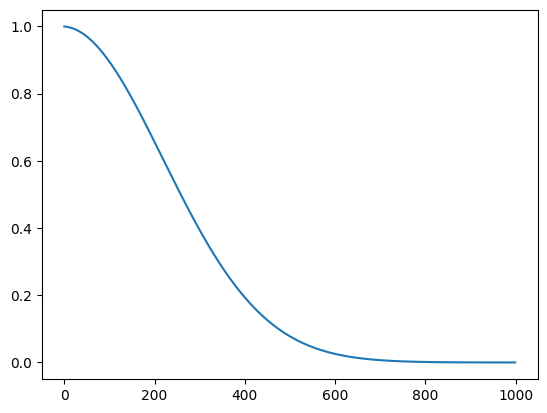

In [29]:
plt.plot(noise_scheduler.alphas_cumprod.cpu().numpy())
plt.show()


In [1]:
noise_scheduler.set_timesteps(100)

NameError: name 'noise_scheduler' is not defined

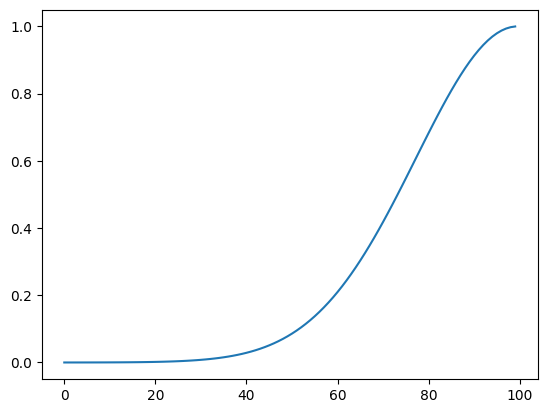

In [32]:
noise_scheduler.timesteps.cpu().numpy()
plt.plot(noise_scheduler.alphas_cumprod.cpu().numpy()[noise_scheduler.timesteps.cpu().numpy()])
plt.show()